<a href="https://colab.research.google.com/github/amkayhani/FAIDM/blob/main/AssociationRuleDimensionReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Association Rule Mining & Dimension Reduction  
### Module tutor: Dr Ruohan Zhang


This practical session is designed to accompany the lectures on:

- **Association Rule Mining**
- **Dimension Reduction**

You will follow a structured workflow that mirrors what we covered in the lecture slides.


# Introduction

In this workshop, we will:

- Prepare transactional and numerical datasets
- Apply Apriori to discover frequent itemsets and rules
- Calculate and interpret support, confidence, and lift
- Perform PCA to reduce dimensionality and visualise structure
- Practice with structured exercises covering both methods

The goal is to help you build confidence with Python-based pattern discovery and dimension reduction techniques commonly used in data mining workflows.
# Setup

In [23]:
# Install required libraries (quiet mode)
# !pip install mlxtend --quiet
# !pip install pandas numpy matplotlib seaborn scikit-learn --quiet


# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")


# PART 1 — ASSOCIATION RULE MINING

# Load and Inspect the Dataset

**Learning Objectives**
* Load a transactional retail-style dataset suitable for association rule mining (https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci?resource=download).
* Understand the structure: transactions, items, quantities.
* Identify potential data quality issues.

We will use a public Online Retail II sample dataset (UCI-based public teaching subset).

In [24]:
# Generate a dataset
import pandas as pd
import numpy as np


df = pd.read_csv(r"CDC Diabetes Dataset.csv")


df.head()


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [25]:
df.isna().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

# Data Cleaning and Preparation

This step is used to:
* Check for and handle missing values
* Understand the structure of the diabetes dataset
* Prepare binary features for association rule mining

Association rule mining requires clean, binary-encoded transactional data.

In [26]:
# Check dataset shape and basic info
print(f"Dataset shape: {df.shape}")
print(f"\nMissing values:\n{df.isna().sum()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nBasic statistics:\n{df.describe()}")

Dataset shape: (253680, 22)

Missing values:
Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

Data types:
Diabetes_012            float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAl

# Feature Engineering for Association Rules

For association rule mining, we need binary features. The dataset contains:
* **Binary features** (already 0/1): HighBP, HighChol, Smoker, Stroke, etc.
* **Categorical features**: GenHlth, Age, Education, Income (need binning)
* **Continuous features**: BMI, MentHlth, PhysHlth (need binning)

We'll create meaningful categories and label them for interpretability.

In [9]:
# Create a copy for feature engineering
df_arm = df.copy()

# Create binary diabetes feature (merge prediabetes and diabetes)
df_arm['HasDiabetes'] = (df['Diabetes_012'] >= 1).astype(int)

# Bin BMI into categories
df_arm['BMI_Underweight'] = (df['BMI'] < 18.5).astype(int)
df_arm['BMI_Normal'] = ((df['BMI'] >= 18.5) & (df['BMI'] < 25)).astype(int)
df_arm['BMI_Overweight'] = ((df['BMI'] >= 25) & (df['BMI'] < 30)).astype(int)
df_arm['BMI_Obese'] = (df['BMI'] >= 30).astype(int)

# Bin GenHlth (1=excellent to 5=poor)
df_arm['Health_Excellent'] = (df['GenHlth'] == 1).astype(int)
df_arm['Health_VeryGood'] = (df['GenHlth'] == 2).astype(int)
df_arm['Health_Good'] = (df['GenHlth'] == 3).astype(int)
df_arm['Health_Fair'] = (df['GenHlth'] == 4).astype(int)
df_arm['Health_Poor'] = (df['GenHlth'] == 5).astype(int)

# Bin Age (1-13 age groups)
df_arm['Age_Young'] = (df['Age'] <= 4).astype(int)  # 18-44
df_arm['Age_Middle'] = ((df['Age'] > 4) & (df['Age'] <= 9)).astype(int)  # 45-64
df_arm['Age_Senior'] = (df['Age'] > 9).astype(int)  # 65+

# Bin Mental Health (days of poor mental health in past 30 days)
df_arm['MentHlth_None'] = (df['MentHlth'] == 0).astype(int)
df_arm['MentHlth_Few'] = ((df['MentHlth'] > 0) & (df['MentHlth'] <= 7)).astype(int)
df_arm['MentHlth_Many'] = (df['MentHlth'] > 7).astype(int)

# Bin Physical Health (days of poor physical health in past 30 days)
df_arm['PhysHlth_None'] = (df['PhysHlth'] == 0).astype(int)
df_arm['PhysHlth_Few'] = ((df['PhysHlth'] > 0) & (df['PhysHlth'] <= 7)).astype(int)
df_arm['PhysHlth_Many'] = (df['PhysHlth'] > 7).astype(int)

# Bin Income (1-8 income levels)
df_arm['Income_Low'] = (df['Income'] <= 3).astype(int)  # <$25k
df_arm['Income_Medium'] = ((df['Income'] > 3) & (df['Income'] <= 6)).astype(int)  # $25k-$50k
df_arm['Income_High'] = (df['Income'] > 6).astype(int)  # >$50k

# Bin Education (1-6 education levels)
df_arm['Edu_LowMid'] = (df['Education'] <= 3).astype(int)  # < High school graduate
df_arm['Edu_HighGrad'] = (df['Education'] == 4).astype(int)  # High school graduate
df_arm['Edu_College'] = (df['Education'] > 4).astype(int)  # Some college or higher

print("Feature engineering completed!")
print(f"New dataset shape: {df_arm.shape}")
df_arm.head()


Feature engineering completed!
New dataset shape: (253680, 47)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,MentHlth_Many,PhysHlth_None,PhysHlth_Few,PhysHlth_Many,Income_Low,Income_Medium,Income_High,Edu_LowMid,Edu_HighGrad,Edu_College
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,1,1,0,0,0,1,0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0,1,0,0,1,0,0,0,0,1
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,1,0,0,1,0,1,0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,0,0,1,0,1,0,0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,0,0,1,0,0,0,1


In [30]:
# Build basket matrix - select binary features only
# Exclude the original multi-class target (Diabetes_012) and original continuous/categorical variables
# Note: HasDiabetes (binary version) will be included in the basket
exclude_cols = ['Diabetes_012', 'BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

# Select binary columns (both original binary and newly created)
binary_features = [col for col in df_arm.columns if col not in exclude_cols]

# Create basket matrix
basket = df_arm[binary_features].astype(bool)

print(f"Basket matrix shape: {basket.shape}")
print(f"\nFeatures included in basket:")
print(binary_features)
print(f"\nBasket matrix preview:")
basket.head(10)

Basket matrix shape: (253680, 39)

Features included in basket:
['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex', 'HasDiabetes', 'BMI_Underweight', 'BMI_Normal', 'BMI_Overweight', 'BMI_Obese', 'Health_Excellent', 'Health_VeryGood', 'Health_Good', 'Health_Fair', 'Health_Poor', 'Age_Young', 'Age_Middle', 'Age_Senior', 'MentHlth_None', 'MentHlth_Few', 'MentHlth_Many', 'PhysHlth_None', 'PhysHlth_Few', 'PhysHlth_Many', 'Income_Low', 'Income_Medium', 'Income_High', 'Edu_LowMid', 'Edu_HighGrad', 'Edu_College']

Basket matrix preview:


,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,MentHlth_Many,PhysHlth_None,PhysHlth_Few,PhysHlth_Many,Income_Low,Income_Medium,Income_High,Edu_LowMid,Edu_HighGrad,Edu_College
0,True,True,True,True,False,False,False,False,True,False,...,True,False,False,True,True,False,False,False,True,False
1,False,False,False,True,False,False,True,False,False,False,...,False,True,False,False,True,False,False,False,False,True
2,True,True,True,False,False,False,False,True,False,False,...,True,False,False,True,False,False,True,False,True,False
3,True,False,True,False,False,False,True,True,True,False,...,False,True,False,False,False,True,False,True,False,False
4,True,True,True,False,False,False,True,True,True,False,...,False,True,False,False,False,True,False,False,False,True
5,True,True,True,True,False,False,True,True,True,False,...,False,False,True,False,False,False,True,False,False,True
6,True,False,True,True,False,False,False,False,False,False,...,False,False,False,True,False,False,True,False,False,True
7,True,True,True,True,False,False,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False
8,True,True,True,True,False,True,False,True,True,False,...,True,False,False,True,True,False,False,False,False,True
9,False,False,True,False,False,False,False,False,True,False,...,False,True,False,False,True,False,False,False,True,False


# Convert to Basket Format (Transaction × Item Matrix)

This step is used to:
* Select binary features for association rule mining
* Create a basket matrix where each row represents a patient
* Each column represents a health condition/characteristic (item)
* Values = 1 if condition is present, 0 otherwise

**Basket Matrix Interpretation**
* Each row represents a patient (transaction)
* Each column represents a health condition or characteristic (item)
* Matrix contains 0/1 values (required by Apriori)
* This format lets us discover frequently co-occurring health conditions

# Frequent Itemset Mining (Apriori)
This step is used to:
* Apply the Apriori algorithm
* Identify product combinations that appear together often
* Understand the effect of min_support

In [31]:
# Sample the data for computational efficiency - stratified by diabetes status
from sklearn.model_selection import train_test_split

# Take a stratified sample of 30,000 patients (preserves diabetes distribution)
basket_sample, _ = train_test_split(
    basket, 
    test_size=0.88,  # Keep ~12% of data
    stratify=basket['HasDiabetes'],
    random_state=42
)

print(f"Original basket size: {basket.shape}")
print(f"Sample basket size: {basket_sample.shape}")
print(f"\nDiabetes distribution in sample:")
print(basket_sample['HasDiabetes'].value_counts(normalize=True))


Original basket size: (253680, 39)
Sample basket size: (30441, 39)

Diabetes distribution in sample:
HasDiabetes
False    0.842416
True     0.157584
Name: proportion, dtype: float64


# Sample Data for Computational Efficiency

Due to the large size of the dataset (250K+ rows), we'll take a stratified sample to make association rule mining computationally feasible while preserving the distribution of diabetes cases.


In [19]:
from mlxtend.frequent_patterns import apriori

# Find frequent itemsets using sampled data
# Lower min_support to capture diabetes-related patterns (diabetes prevalence ~15%)
frequent_itemsets = apriori(
    basket_sample,
    min_support=0.05,  # Items/combinations appearing in at least 5% of patients
    use_colnames=True,
    max_len=3  # Limit to 3-item combinations for computational efficiency
)

frequent_itemsets = frequent_itemsets.sort_values("support", ascending=False)
print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")
frequent_itemsets.head(20)


Number of frequent itemsets found: 2323


,support,itemsets
2,0.961729,frozenset({CholCheck})
9,0.952695,frozenset({AnyHealthcare})
101,0.921717,"frozenset({AnyHealthcare, CholCheck})"
7,0.809665,frozenset({Veggies})
99,0.779574,"frozenset({Veggies, CholCheck})"
219,0.774318,"frozenset({Veggies, AnyHealthcare})"
5,0.753983,frozenset({PhysActivity})
996,0.749745,"frozenset({Veggies, AnyHealthcare, CholCheck})"
97,0.725699,"frozenset({PhysActivity, CholCheck})"
167,0.721330,"frozenset({PhysActivity, AnyHealthcare})"


**Frequent Itemsets Interpretation**
* Each row represents a health condition or combination of conditions
* **Support** = proportion of patients with that condition combination
* Higher support means more common condition patterns
* Identifies which health conditions frequently occur together in the population

# Generate Association Rules
This step is used to:
* Generate rules from frequent itemsets
* Calculate support, confidence, and lift
* Sort rules to find the most meaningful patterns

In [20]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)

rules = rules.sort_values("lift", ascending=False)
rules.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
6055,frozenset({DiffWalk}),"frozenset({PhysHlth_Many, HighBP})",0.171019,0.097829,0.060938,0.356320,3.642285,1.0,0.044207,1.401583,0.875107,0.293095,0.286521,0.489610
6050,"frozenset({PhysHlth_Many, HighBP})",frozenset({DiffWalk}),0.097829,0.171019,0.060938,0.622901,3.642285,1.0,0.044207,2.198312,0.804112,0.293095,0.545106,0.489610
6611,frozenset({DiffWalk}),"frozenset({Smoker, PhysHlth_Many})",0.171019,0.091620,0.055156,0.322512,3.520116,1.0,0.039487,1.340807,0.863613,0.265833,0.254181,0.462260
6606,"frozenset({Smoker, PhysHlth_Many})",frozenset({DiffWalk}),0.091620,0.171019,0.055156,0.602008,3.520116,1.0,0.039487,2.082907,0.788126,0.265833,0.519902,0.462260
6691,frozenset({DiffWalk}),"frozenset({PhysHlth_Many, HighChol})",0.171019,0.090930,0.054203,0.316942,3.485560,1.0,0.038652,1.330883,0.860216,0.260911,0.248619,0.456520
6686,"frozenset({PhysHlth_Many, HighChol})",frozenset({DiffWalk}),0.090930,0.171019,0.054203,0.596098,3.485560,1.0,0.038652,2.052432,0.784430,0.260911,0.512773,0.456520
6607,"frozenset({Smoker, DiffWalk})",frozenset({PhysHlth_Many}),0.098223,0.164614,0.055156,0.561538,3.411254,1.0,0.038987,1.905267,0.783844,0.265581,0.475139,0.448301
6610,frozenset({PhysHlth_Many}),"frozenset({Smoker, DiffWalk})",0.164614,0.098223,0.055156,0.335063,3.411254,1.0,0.038987,1.356184,0.846138,0.265581,0.262637,0.448301
6689,frozenset({PhysHlth_Many}),"frozenset({HighChol, DiffWalk})",0.164614,0.100095,0.054203,0.329276,3.289622,1.0,0.037726,1.341691,0.833164,0.257491,0.254672,0.435396
6688,"frozenset({HighChol, DiffWalk})",frozenset({PhysHlth_Many}),0.100095,0.164614,0.054203,0.541516,3.289622,1.0,0.037726,1.822063,0.773430,0.257491,0.451172,0.435396


**Interpretation of Association Rules for Diabetes Dataset**

The generated association rules reveal relationships between health conditions and characteristics. Each rule shows patterns like: "If a patient has condition A, they are also likely to have condition B."

**Key Metrics Explained:**

**1. Support**
* Represents how frequently the condition combination appears in the dataset
* Example: support = 0.45 means 45% of patients have this combination
* High support indicates common health patterns in the population

**2. Confidence**
* Measures how often the rule is correct
* Example: confidence = 0.80 means:
  - 80% of patients with the antecedent conditions also have the consequent condition
* Confidence near 1.0 indicates very reliable co-occurrence

**3. Lift**
* Shows how much more likely the consequent is when the antecedent is present, compared to random chance
* **Lift = 1** → no real association; co-occurrence is due to chance
* **Lift > 1** → positive association; conditions appear together more than expected
* **Lift < 1** → negative association; conditions occur together less than expected
* Example: lift = 2.5 means the consequent is 2.5× more likely with the antecedent

**Health Insights:**
* Rules with high lift reveal strong health condition dependencies
* High confidence + high lift = reliable predictive patterns
* These patterns can inform:
  - Risk factor identification
  - Preventive care strategies
  - Comorbidity patterns
  - Healthcare resource allocation

# Filter Strong Rules (High Lift and Confidence)

This step is used to:
* Apply thresholds to identify actionable health patterns
* Focus on rules with strong predictive power
* Interpret results in a healthcare context

In [15]:
# Filter strong rules with meaningful lift and confidence
strong_rules = rules[
    (rules["lift"] > 1.2) &  # At least 20% increase in likelihood
    (rules["confidence"] > 0.6) &  # At least 60% reliability
    (rules["support"] > 0.01)  # Appears in at least 1% of patients
].sort_values("lift", ascending=False)

print(f"Number of strong rules found: {len(strong_rules)}")
print("\nTop 10 strongest association rules:")
strong_rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(10)

Number of strong rules found: 3899

Top 10 strongest association rules:


,antecedents,consequents,support,confidence,lift
41553,"frozenset({Fruits, Income_High, PhysHlth_None})","frozenset({PhysActivity, MentHlth_None, Edu_Co...",0.151703,0.613117,1.584776
41526,"frozenset({Fruits, Income_High, PhysHlth_None,...","frozenset({PhysActivity, MentHlth_None, Edu_Co...",0.151703,0.625406,1.572868
37013,"frozenset({Fruits, Income_High, MentHlth_None,...","frozenset({PhysHlth_None, Veggies, Edu_College})",0.157156,0.609971,1.571040
41097,"frozenset({Fruits, Income_High, PhysHlth_None,...","frozenset({Veggies, MentHlth_None, Edu_College...",0.152065,0.637515,1.570368
41040,"frozenset({CholCheck, Fruits, MentHlth_None, I...","frozenset({PhysHlth_None, Veggies, Edu_College})",0.152065,0.609239,1.569156
41168,"frozenset({Fruits, Income_High, PhysHlth_None})","frozenset({Edu_College, CholCheck, MentHlth_No...",0.152065,0.614578,1.566471
35522,"frozenset({Fruits, Income_High, MentHlth_None})","frozenset({PhysHlth_None, Veggies, Edu_College})",0.159522,0.607760,1.565345
39405,"frozenset({Fruits, Income_High, MentHlth_None,...","frozenset({PhysHlth_None, Veggies, Edu_College})",0.154069,0.607670,1.565115
37044,"frozenset({Fruits, Income_High, PhysHlth_None})","frozenset({Veggies, MentHlth_None, Edu_College...",0.157156,0.635157,1.564558
39551,"frozenset({Fruits, Income_High, PhysHlth_None})","frozenset({PhysActivity, MentHlth_None, Edu_Co...",0.153904,0.622013,1.564333


In [32]:
# Filter rules with HasDiabetes as consequent
diabetes_consequent = rules[rules["consequents"].apply(lambda x: "HasDiabetes" in x)].copy()
diabetes_consequent = diabetes_consequent.sort_values("lift", ascending=False)

print(f"Rules with HasDiabetes as consequent: {len(diabetes_consequent)}")
diabetes_consequent[["antecedents", "consequents", "support", "confidence", "lift"]].head(20)

Rules with HasDiabetes as consequent: 162


,antecedents,consequents,support,confidence,lift
5422,"frozenset({HighBP, BMI_Obese})",frozenset({HasDiabetes}),0.069774,0.358723,2.276400
6242,"frozenset({HighChol, BMI_Obese})",frozenset({HasDiabetes}),0.058901,0.348291,2.210197
6581,"frozenset({DiffWalk, CholCheck})",frozenset({HasDiabetes}),0.055287,0.330324,2.096183
6772,"frozenset({DiffWalk, AnyHealthcare})",frozenset({HasDiabetes}),0.053612,0.328502,2.084624
4586,"frozenset({HighBP, HighChol})",frozenset({HasDiabetes}),0.083440,0.328293,2.083293
6775,frozenset({DiffWalk}),"frozenset({HasDiabetes, AnyHealthcare})",0.053612,0.313484,2.075871
6501,frozenset({DiffWalk}),frozenset({HasDiabetes}),0.055911,0.326930,2.074649
6585,frozenset({DiffWalk}),"frozenset({HasDiabetes, CholCheck})",0.055287,0.323281,2.072224
5740,"frozenset({HighBP, Age_Senior})",frozenset({HasDiabetes}),0.065011,0.300349,1.905967
4588,frozenset({HighBP}),"frozenset({HasDiabetes, HighChol})",0.083440,0.195309,1.873752


**Understanding Strong Rules in Healthcare Context**

Strong association rules (high lift + high confidence) reveal important health patterns:

* **High Lift (> 1.2)**: Conditions that significantly increase the likelihood of other conditions
* **High Confidence (> 0.6)**: Reliable patterns that hold true in most cases
* **Minimum Support (> 0.01)**: Patterns that affect a meaningful portion of the population

**Clinical Significance:**
* These rules can identify:
  - Comorbidity patterns (diseases that occur together)
  - Risk factor combinations
  - Lifestyle and health outcome relationships
  - Preventive care opportunities

**Example interpretation:**
If a rule shows: {HighBP, BMI_Obese} → {HeartDiseaseorAttack} with lift=2.5 and confidence=0.75:
* Patients with high blood pressure AND obesity are 2.5× more likely to have heart disease
* This pattern is reliable (75% of the time)
* Suggests targeted interventions for this high-risk group

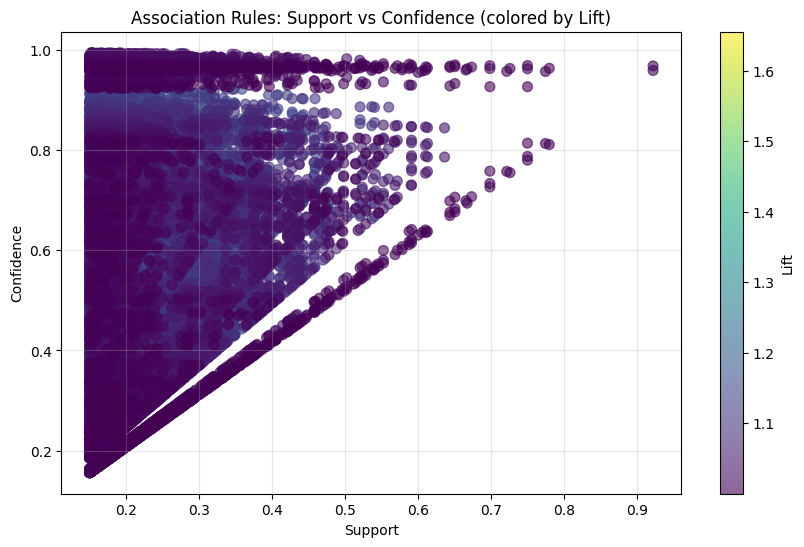

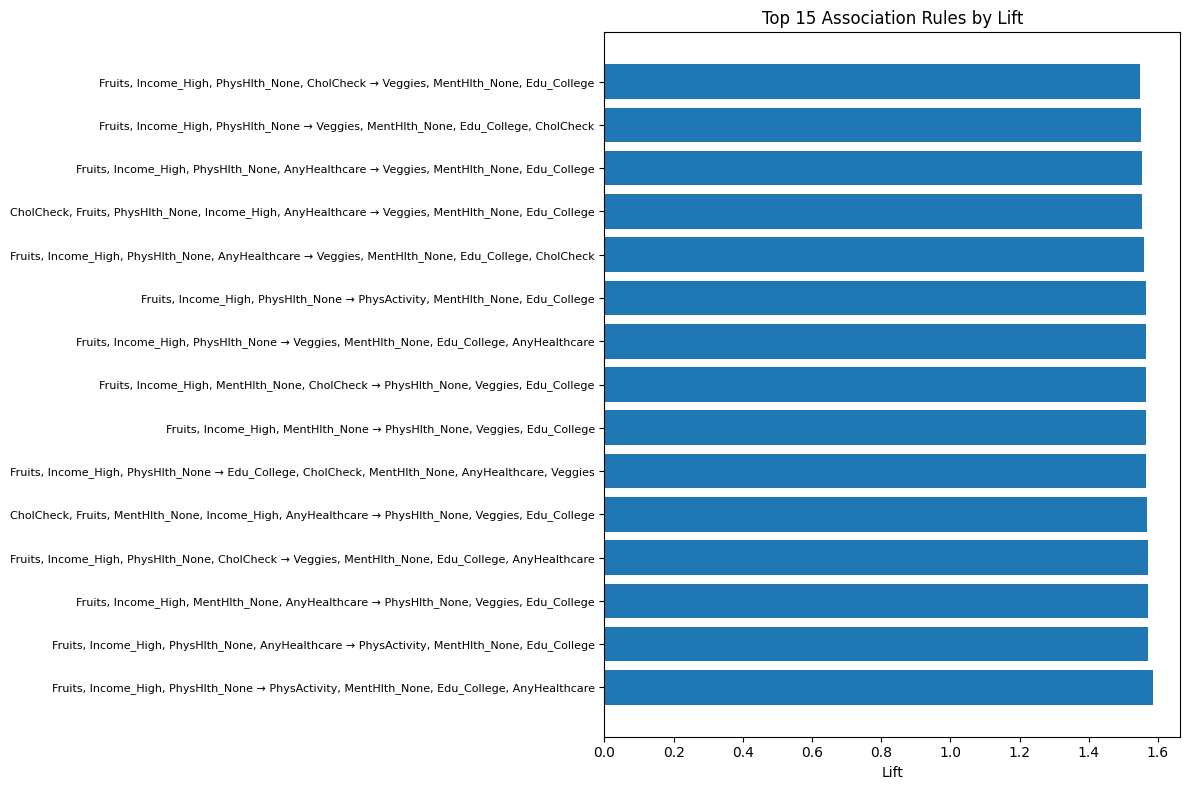

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of support vs confidence, colored by lift
plt.figure(figsize=(10, 6))
scatter = plt.scatter(rules['support'], rules['confidence'], 
                     c=rules['lift'], cmap='viridis', 
                     alpha=0.6, s=50)
plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (colored by Lift)')
plt.grid(True, alpha=0.3)
plt.show()

# Top 15 rules by lift
if len(strong_rules) > 0:
    top_rules = strong_rules.head(15).copy()
    
    # Create rule labels
    top_rules['rule'] = top_rules.apply(
        lambda x: f"{', '.join([str(i) for i in x['antecedents']])} → {', '.join([str(i) for i in x['consequents']])}",
        axis=1
    )
    
    # Plot lift values
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_rules)), top_rules['lift'])
    plt.yticks(range(len(top_rules)), top_rules['rule'], fontsize=8)
    plt.xlabel('Lift')
    plt.title('Top 15 Association Rules by Lift')
    plt.tight_layout()
    plt.show()
else:
    print("No strong rules found with current thresholds. Try lowering the lift or confidence thresholds.")

# Rules Involving Diabetes

Let's examine association rules that specifically involve the diabetes feature to understand what health conditions and characteristics are associated with diabetes.


# Visualize Association Rules

In [21]:
# Find rules where HasDiabetes is the consequent (what predicts diabetes)
# Check all rules first, not just strong_rules
diabetes_consequent = rules[
    rules['consequents'].apply(lambda x: 'HasDiabetes' in x)
].sort_values('lift', ascending=False)

print(f"Total rules predicting diabetes: {len(diabetes_consequent)}")
print(f"\nTop 20 rules predicting diabetes (sorted by lift):")
print("="*100)
diabetes_consequent[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20)


Total rules predicting diabetes: 162

Top 20 rules predicting diabetes (sorted by lift):


,antecedents,consequents,support,confidence,lift
5422,"frozenset({HighBP, BMI_Obese})",frozenset({HasDiabetes}),0.069774,0.358723,2.276400
6242,"frozenset({HighChol, BMI_Obese})",frozenset({HasDiabetes}),0.058901,0.348291,2.210197
6581,"frozenset({DiffWalk, CholCheck})",frozenset({HasDiabetes}),0.055287,0.330324,2.096183
6772,"frozenset({DiffWalk, AnyHealthcare})",frozenset({HasDiabetes}),0.053612,0.328502,2.084624
4586,"frozenset({HighBP, HighChol})",frozenset({HasDiabetes}),0.083440,0.328293,2.083293
6775,frozenset({DiffWalk}),"frozenset({HasDiabetes, AnyHealthcare})",0.053612,0.313484,2.075871
6501,frozenset({DiffWalk}),frozenset({HasDiabetes}),0.055911,0.326930,2.074649
6585,frozenset({DiffWalk}),"frozenset({HasDiabetes, CholCheck})",0.055287,0.323281,2.072224
5740,"frozenset({HighBP, Age_Senior})",frozenset({HasDiabetes}),0.065011,0.300349,1.905967
4588,frozenset({HighBP}),"frozenset({HasDiabetes, HighChol})",0.083440,0.195309,1.873752


In [22]:
# Find rules where HasDiabetes is the antecedent (what diabetes predicts)
diabetes_antecedent = rules[
    rules['antecedents'].apply(lambda x: 'HasDiabetes' in x)
].sort_values('lift', ascending=False)

print(f"Total rules with diabetes as predictor: {len(diabetes_antecedent)}")
print(f"\nTop 20 rules with diabetes as predictor (sorted by lift):")
print("="*100)
diabetes_antecedent[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(20)


Total rules with diabetes as predictor: 162

Top 20 rules with diabetes as predictor (sorted by lift):


,antecedents,consequents,support,confidence,lift
5423,frozenset({HasDiabetes}),"frozenset({HighBP, BMI_Obese})",0.069774,0.442777,2.276400
6243,frozenset({HasDiabetes}),"frozenset({HighChol, BMI_Obese})",0.058901,0.373775,2.210197
6584,frozenset({HasDiabetes}),"frozenset({DiffWalk, CholCheck})",0.055287,0.350844,2.096183
6773,frozenset({HasDiabetes}),"frozenset({DiffWalk, AnyHealthcare})",0.053612,0.340213,2.084624
4587,frozenset({HasDiabetes}),"frozenset({HighBP, HighChol})",0.083440,0.529498,2.083293
6770,"frozenset({HasDiabetes, AnyHealthcare})",frozenset({DiffWalk}),0.053612,0.355014,2.075871
6500,frozenset({HasDiabetes}),frozenset({DiffWalk}),0.055911,0.354805,2.074649
6580,"frozenset({HasDiabetes, CholCheck})",frozenset({DiffWalk}),0.055287,0.354390,2.072224
5741,frozenset({HasDiabetes}),"frozenset({HighBP, Age_Senior})",0.065011,0.412550,1.905967
4585,"frozenset({HasDiabetes, HighChol})",frozenset({HighBP}),0.083440,0.800504,1.873752
